In [26]:
import numpy as np
import pandas as pd


from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from optuna import Study, Trial
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna

from model.wrapper import RoundingWrapper
from model.scoring import cross_val_splits, kicktipp_scoring
from model.simple_models import StaticEstimator
from model.simple_models import LatestTableEstimator
from model.plots import cross_val_plot

In [27]:
DEBUG = True

In [28]:
df_matches = pd.read_csv("./data/matches.csv")

## Static Results

2:1:	361.900 +- 24.353
1:0:	355.800 +- 28.621
1:1:	225.600 +- 15.409
0:0:	188.800 +- 15.930


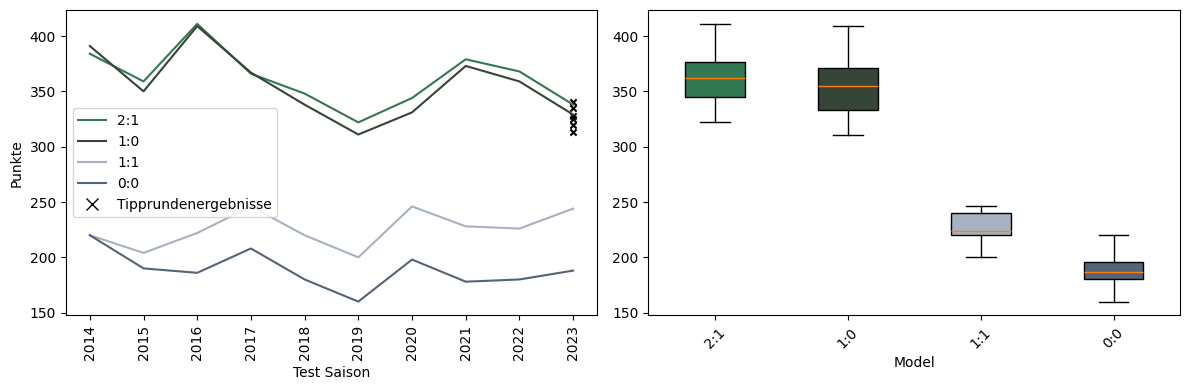

In [29]:
import colors

splits = cross_val_splits(df_matches, start=4)
y_train = df_matches[["host_goals", "guest_goals"]].values

static_results = [
    [0, 0],
    [1, 1],
    [1, 0], 
    [2, 1],
]
bar_colors = [
    colors.GRAY_D,
    colors.GRAY,
    colors.GRASS_D,
    colors.GRASS,
]

models = [StaticEstimator(result) for result in static_results]
labels = [f"{r[0]}:{r[1]}" for r in static_results]
scores = [cross_val_score(model, df_matches, y_train, cv=splits, scoring=kicktipp_scoring) for model in models]

fig, axs = cross_val_plot(df_matches, splits, labels, scores, color=bar_colors)
real_results = [340, 335, 328, 325, 320, 313]
axs[0].scatter([9] * len(real_results), real_results, s=20, marker="x", color="black")
handles = axs[0].get_legend().legend_handles

from matplotlib.lines import Line2D
axs[0].legend(handles=handles + [Line2D([], [], linestyle='None', marker='x', color='black', label='Tipprundenergebnisse', markersize=8)])
fig.tight_layout()


## Based on table 

Table-based:	374.700 +- 26.306
2:1:	361.900 +- 24.353


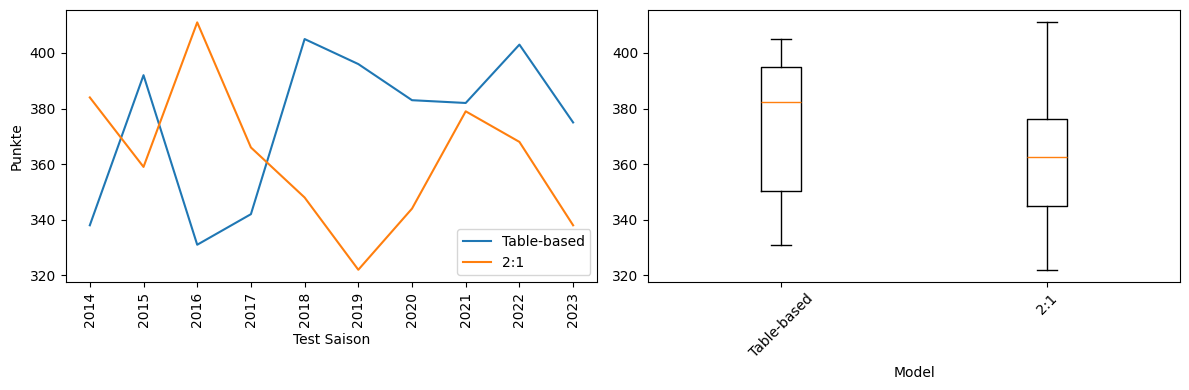

In [30]:

models = [StaticEstimator([2, 1]), LatestTableEstimator()]
labels = ["2:1", "Table-based"]
scores = [cross_val_score(model, df_matches, y_train, cv=splits, scoring=kicktipp_scoring) for model in models]

fig, axs = cross_val_plot(df_matches, splits, labels, scores)

# Matches with team context

In [31]:
df_matches = df_matches.fillna(0)
df_matches.tail()

,id,match_day,season,host_id,host_name,guest_id,guest_name,host_goals,guest_goals,host_last_season_draws,...,diff_last_season_opponent_goals,diff_last_season_points,diff_last_season_wins,diff_horizon_points,diff_horizon_goals,diff_horizon_opponent_goals,diff_horizon_goal_diff,diff_horizon_wins,diff_horizon_draws,diff_horizon_defeats
4279,66932,34,2023,131,Wolfsburg,81,Mainz,1.0,3.0,10.0,...,-7.0,3.0,1.0,7.000000,6.000000,-5.666667,11.666667,2.333333,0.000000,-2.333333
4280,66933,34,2023,175,Hoffenheim,40,Bayern,4.0,2.0,6.0,...,19.0,-35.0,-11.0,-33.666667,-43.333333,17.333333,-60.666667,-11.666667,1.333333,10.333333
4281,66934,34,2023,134,Bremen,129,Bochum,4.0,1.0,6.0,...,-8.0,1.0,0.0,-5.000000,4.500000,-1.500000,6.000000,-2.500000,2.500000,0.000000
4282,66935,34,2023,16,Stuttgart,87,Gladbach,4.0,0.0,12.0,...,2.0,-10.0,-4.0,-8.666667,-9.333333,-0.333333,-9.000000,-3.333333,1.333333,2.000000
4283,66936,34,2023,199,Heidenheim,65,Köln,4.0,1.0,0.0,...,-54.0,-42.0,-10.0,-42.333333,-45.000000,-54.333333,-90.666667,-10.666667,-10.333333,-13.000000


In [32]:
X_all = df_matches.drop(columns=["host_name", "guest_name", "host_goals", "guest_goals"])
y_all = df_matches[["host_goals", "guest_goals"]].values
print(X_all.columns)
features = [
    # "season",
    # "host_id",
    # "guest_id",
    "diff_last_season_goals",
    "diff_last_season_points",
    "diff_horizon_points",
    "diff_horizon_goals"
]
X_all = X_all[features]

Index(['id', 'match_day', 'season', 'host_id', 'guest_id',
       'host_last_season_draws', 'host_last_season_goal_diff',
       'host_last_season_goals', 'host_last_season_defeats',
       'host_last_season_matches', 'host_last_season_opponent_goals',
       'host_last_season_points', 'host_last_season_wins',
       'guest_last_season_draws', 'guest_last_season_goal_diff',
       'guest_last_season_goals', 'guest_last_season_defeats',
       'guest_last_season_matches', 'guest_last_season_opponent_goals',
       'guest_last_season_points', 'guest_last_season_wins',
       'host_horizon_points', 'host_horizon_goals',
       'host_horizon_opponent_goals', 'host_horizon_goal_diff',
       'host_horizon_wins', 'host_horizon_draws', 'host_horizon_defeats',
       'guest_horizon_points', 'guest_horizon_goals',
       'guest_horizon_opponent_goals', 'guest_horizon_goal_diff',
       'guest_horizon_wins', 'guest_horizon_draws', 'guest_horizon_defeats',
       'diff_last_season_draws', 'diff_l

In [33]:
X_all

,diff_last_season_goals,diff_last_season_points,diff_horizon_points,diff_horizon_goals
0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.000000,0.000000
...,...,...,...,...
4279,3.0,3.0,7.000000,6.000000
4280,-44.0,-35.0,-33.666667,-43.333333
4281,11.0,1.0,-5.000000,4.500000
4282,-7.0,-10.0,-8.666667,-9.333333


## Random Forest

In [34]:
splits = cross_val_splits(df_matches, start=3)

def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 75)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    estimator = RoundingWrapper(RandomForestRegressor(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=4
    ))
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf", load_if_exists=True)
rf_study.optimize(objective, n_trials=2 if DEBUG else 50)
print(rf_study.best_value, rf_study.best_params)

[I 2024-09-15 01:47:14,928] Using an existing study with name 'rf' instead of creating a new one.
[I 2024-09-15 01:47:15,626] Trial 499 finished with value: 392.0 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 42, 'min_samples_split': 36}. Best is trial 296 with value: 397.8181818181818.
[I 2024-09-15 01:47:16,218] Trial 500 finished with value: 358.0 and parameters: {'criterion': 'friedman_mse', 'max_depth': 3, 'n_estimators': 41, 'min_samples_split': 43}. Best is trial 296 with value: 397.8181818181818.


397.8181818181818 {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 41, 'min_samples_split': 30}


In [35]:
def build_rf_model(study):
    best_params = study.best_params
    return RoundingWrapper(RandomForestRegressor(
        n_estimators=best_params['n_estimators'], 
        criterion=best_params['criterion'], 
        max_depth=best_params['max_depth'], 
        min_samples_split=best_params['min_samples_split'],
        n_jobs=4
    ))
    

## Gradient Boosting

In [36]:
def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 25, 75)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = RoundingWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ))
    elif algo == "lgbm":
        estimator = RoundingWrapper(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        )))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb", load_if_exists=True)
gb_study.optimize(objective, n_trials=2 if DEBUG else 200)
print(gb_study.best_value, gb_study.best_params)

[I 2024-09-15 01:47:16,359] Using an existing study with name 'gb' instead of creating a new one.
[I 2024-09-15 01:47:17,241] Trial 1423 finished with value: 391.6363636363636 and parameters: {'algo': 'lgbm', 'n_estimators': 49, 'max_depth': 7, 'lambda': 1.6746977473784208, 'alpha': 0.21526537243644522, 'learning_rate': 0.23632197115214928, 'num_leaves': 2, 'min_child_weight': 4.278462814256453, 'objective-lgbm': 'poisson'}. Best is trial 1344 with value: 394.27272727272725.
[I 2024-09-15 01:47:17,572] Trial 1424 finished with value: 296.09090909090907 and parameters: {'algo': 'lgbm', 'n_estimators': 33, 'max_depth': 6, 'lambda': 1.7233237131851384, 'alpha': 0.24768190466820583, 'learning_rate': 0.27019320223695764, 'num_leaves': 2, 'min_child_weight': 4.883168406735971, 'objective-lgbm': 'mae'}. Best is trial 1344 with value: 394.27272727272725.


394.27272727272725 {'algo': 'lgbm', 'n_estimators': 32, 'max_depth': 6, 'lambda': 1.6873564096799774, 'alpha': 0.34409049384987345, 'learning_rate': 0.26523360985678973, 'num_leaves': 3, 'min_child_weight': 4.6450353998626195, 'objective-lgbm': 'poisson'}


In [37]:
def build_gb_model(study):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda=params["lambda"]
    reg_alpha=params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves=params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    if algo == "xgb":
        estimator = RoundingWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-xgb"],
        ))
    elif algo == "lgbm":
        estimator = RoundingWrapper(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-lgbm"],
        )))
    return estimator
    

## SVR

In [38]:
def objective(trial: Trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 4)
    else:
        degree = 3
    estimator = RoundingWrapper(MultiOutputRegressor(SVR(
        kernel=kernel,
        degree=degree,
        C=trial.suggest_float("C", 0.0, 3.0)
    )))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

svr_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="svr", load_if_exists=True)
# svr_study.optimize(objective, n_trials=2 if DEBUG else 10)
print(svr_study.best_value, svr_study.best_params)


[I 2024-09-15 01:47:17,608] Using an existing study with name 'svr' instead of creating a new one.


345.90909090909093 {'kernel': 'rbf', 'C': 2.620617117866116}


In [39]:
def build_svr_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(MultiOutputRegressor(SVR(
        kernel=params["kernel"],
        degree=params["degree"] if "degree" in params else 3,
        C=params["C"]
    )))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

## KNN Regressor

In [40]:
def objective(trial: Trial):
    estimator = RoundingWrapper(KNeighborsRegressor(
        n_neighbors=trial.suggest_int("n_neighbors", 5, 100),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric=trial.suggest_categorical("metric", ["cityblock", "cosine", "euclidean", "l1"])
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

knn_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="knn", load_if_exists=True)
knn_study.optimize(objective, n_trials=20 if DEBUG else 200)
print(knn_study.best_value, knn_study.best_params)

def build_knn_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(KNeighborsRegressor(
        n_neighbors=params["n_neighbors"],
        weights=params["weights"],
        metric=params["metric"]
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-15 01:47:17,649] Using an existing study with name 'knn' instead of creating a new one.
[I 2024-09-15 01:47:18,111] Trial 1340 finished with value: 381.3636363636364 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 203 with value: 390.27272727272725.
[I 2024-09-15 01:47:18,315] Trial 1341 finished with value: 382.90909090909093 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 203 with value: 390.27272727272725.
[I 2024-09-15 01:47:18,489] Trial 1342 finished with value: 383.0 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 203 with value: 390.27272727272725.
[I 2024-09-15 01:47:18,680] Trial 1343 finished with value: 382.72727272727275 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 203 with value: 390.27272727272725.
[I 2024-09-15 01:47:18,897] Trial 1344 finished with value: 380.0 and parameters: {'n_n

390.27272727272725 {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'cosine'}


## MLP

In [41]:
def objective(trial: Trial):
    size_1 = trial.suggest_int("size_1", 4, 30)
    size_2 = trial.suggest_int("size_2", 4, 20)
    estimator = RoundingWrapper(MLPRegressor(
        hidden_layer_sizes=(size_1, size_2),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.0001, 0.01),
        max_iter=500
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

mlp_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="mlp", load_if_exists=True)
mlp_study.optimize(objective, n_trials=2 if DEBUG else 20)
print(mlp_study.best_value, mlp_study.best_params)

def build_mlp_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(MLPRegressor(
        hidden_layer_sizes=(params["size_1"], params["size_2"]),
        learning_rate_init=params["learning_rate_init"]
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-15 01:47:22,638] Using an existing study with name 'mlp' instead of creating a new one.
[I 2024-09-15 01:47:24,630] Trial 134 finished with value: 384.45454545454544 and parameters: {'size_1': 9, 'size_2': 13, 'learning_rate_init': 0.0036971047859789144}. Best is trial 36 with value: 390.90909090909093.
[I 2024-09-15 01:47:26,096] Trial 135 finished with value: 379.72727272727275 and parameters: {'size_1': 5, 'size_2': 9, 'learning_rate_init': 0.005331248030010811}. Best is trial 36 with value: 390.90909090909093.


390.90909090909093 {'size_1': 8, 'size_2': 4, 'learning_rate_init': 0.005580153520812897}


/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GB:	394.273 +- 22.337
RF:	393.818 +- 16.286
KNN:	383.273 +- 18.636
MLP:	379.273 +- 18.291
2:1:	362.273 +- 23.250


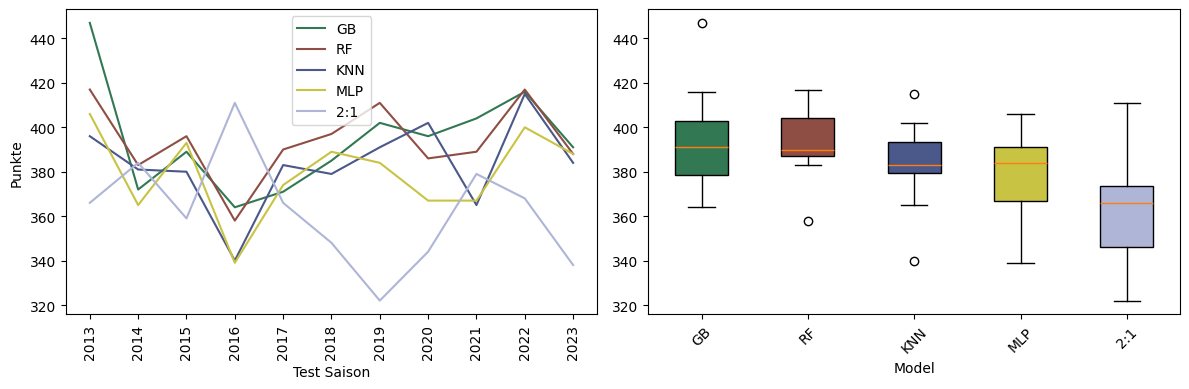

In [42]:

models = {
    #"table-based": LatestTableEstimator(),
    "2:1": StaticEstimator([2, 1]),
    "RF": build_rf_model(rf_study),
    "GB": build_gb_model(gb_study),
    #"svr": build_svr_model(svr_study),
    "KNN": build_knn_model(knn_study),
    "MLP": build_mlp_model(mlp_study)
}
color = [
    colors.BLUE_GRAY,
    colors.BROWNISH,
    colors.GRASS,
    colors.WHALE,
    colors.GOLD
]

labels = list(models.keys())
scores = [cross_val_score(models[name], X_all, y_all, cv=splits, scoring=kicktipp_scoring) for name in models.keys()]

fig, axs = cross_val_plot(df_matches, splits, labels, scores, color=color)


In [43]:
model = build_rf_model(rf_study)
train_idx, test_idx = splits[-2]
X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred_raw = model.regressor.predict(X_train)

df_full_train = df_matches.iloc[train_idx].copy()
df_full_train["team1Goals_pred"] = y_train_pred[:, 0]
df_full_train["team2Goals_pred"] = y_train_pred[:, 1]
df_full_train["team1Goals_pred_raw"] = y_train_pred_raw[:, 0]
df_full_train["team2Goals_pred_raw"] = y_train_pred_raw[:, 1]
df_full_train[["season", "match_day", "host_name", "guest_name", "host_goals", "guest_goals", "team1Goals_pred", "team2Goals_pred"]]

,season,match_day,host_name,guest_name,host_goals,guest_goals,team1Goals_pred,team2Goals_pred
0,2010,1,Bayern,Wolfsburg,2.0,1.0,2.0,1.0
1,2010,1,Hoffenheim,Bremen,4.0,1.0,2.0,1.0
2,2010,1,Gladbach,Nürnberg,1.0,1.0,2.0,1.0
3,2010,1,Köln,Kaiserslautern,1.0,3.0,2.0,1.0
4,2010,1,Freiburg,St. Pauli,1.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...
3667,2021,34,Gladbach,Hoffenheim,5.0,1.0,2.0,1.0
3668,2021,34,Mainz,Frankfurt,2.0,2.0,1.0,2.0
3669,2021,34,Stuttgart,Köln,2.0,1.0,2.0,1.0
3670,2021,34,Union Berlin,Bochum,3.0,2.0,2.0,1.0


<Axes: >

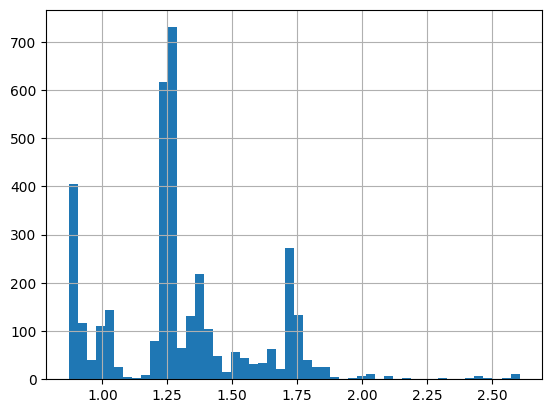

In [44]:
df_full_train["team2Goals_pred_raw"].hist(bins=50)

In [45]:
df_full_train[["team1Goals_pred", "team2Goals_pred"]].value_counts()

team1Goals_pred  team2Goals_pred
2.0              1.0                2490
1.0              2.0                 785
                 1.0                 336
3.0              1.0                  47
1.0              3.0                  14
Name: count, dtype: int64

# Difference Regression

## KNN Diff

In [46]:
from model.wrapper import DifferenceWrapper


def objective(trial: Trial):
    estimator = DifferenceWrapper(KNeighborsRegressor(
        n_neighbors=trial.suggest_int("n_neighbors", 5, 50),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric=trial.suggest_categorical("metric", ["cityblock", "cosine", "euclidean", "l1"]),
    ), base=trial.suggest_float("base", 0.0, 2.0))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

knn_diff_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="knn_diff", load_if_exists=True)
knn_diff_study.optimize(objective, n_trials=20 if DEBUG else 100)
print(knn_diff_study.best_value, knn_diff_study.best_params)

def build_knn_model(study: Study):
    params = study.best_params
    estimator = DifferenceWrapper(KNeighborsRegressor(
        n_neighbors=params["n_neighbors"],
        weights=params["weights"],
        metric=params["metric"]
    ), base=params["base"])
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-15 01:47:29,015] Using an existing study with name 'knn_diff' instead of creating a new one.
[I 2024-09-15 01:47:29,324] Trial 720 finished with value: 290.45454545454544 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'cityblock', 'base': 1.5901992206462476}. Best is trial 104 with value: 364.09090909090907.
[I 2024-09-15 01:47:29,449] Trial 721 finished with value: 351.6363636363636 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'cityblock', 'base': 1.4749279880250572}. Best is trial 104 with value: 364.09090909090907.
[I 2024-09-15 01:47:29,571] Trial 722 finished with value: 310.27272727272725 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'cityblock', 'base': 0.514028979891192}. Best is trial 104 with value: 364.09090909090907.
[I 2024-09-15 01:47:29,701] Trial 723 finished with value: 288.0 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'cityblock', 'base': 1.5212735073550385}. Best 

364.09090909090907 {'n_neighbors': 27, 'weights': 'distance', 'metric': 'cityblock', 'base': 1.4733786004053955}


## GB Diff

In [47]:

def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 50, 50)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = DifferenceWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ), base=trial.suggest_float("basee", 0.0, 2.0))
    elif algo == "lgbm":
        estimator = DifferenceWrapper(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        ), base=trial.suggest_float("basee", 0.0, 2.0))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_diff_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb_diff", load_if_exists=True)
gb_diff_study.optimize(objective, n_trials=2 if DEBUG else 200)
print(gb_diff_study.best_value, gb_diff_study.best_params)

[I 2024-09-15 01:47:31,868] Using an existing study with name 'gb_diff' instead of creating a new one.
[I 2024-09-15 01:47:33,625] Trial 1211 finished with value: 351.3636363636364 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 3, 'lambda': 1.2610276821918682, 'alpha': 1.3636683273928418, 'learning_rate': 0.03210968235871706, 'num_leaves': 10, 'min_child_weight': 8.0844306917938, 'objective-xgb': 'reg:squarederror', 'basee': 1.4207271277214832}. Best is trial 390 with value: 374.1818181818182.
[I 2024-09-15 01:47:36,246] Trial 1212 finished with value: 300.6363636363636 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 5, 'lambda': 0.06784929746059687, 'alpha': 0.6638462694329367, 'learning_rate': 0.040097045035256844, 'num_leaves': 7, 'min_child_weight': 8.955248560562987, 'objective-xgb': 'reg:squarederror', 'basee': 1.5619518174996039}. Best is trial 390 with value: 374.1818181818182.


374.1818181818182 {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 11, 'lambda': 0.08622846025192757, 'alpha': 0.6340768824323674, 'learning_rate': 0.07939655935952164, 'num_leaves': 5, 'min_child_weight': 9.947386150545507, 'objective-xgb': 'reg:squarederror', 'basee': 1.422320514999388}


In [48]:
final_model = build_rf_model(rf_study)

final_model.fit(X_all, y_all)
y_pred = final_model.predict(X_all)
y_pred_raw = final_model.regressor.predict(X_all)

df_full_train = df_matches.copy()
df_full_train["host_goals_pred"] = y_pred[:, 0]
df_full_train["guest_goals_pred"] = y_pred[:, 1]
df_full_train["host_goals_pred_raw"] = y_pred_raw[:, 0]
df_full_train["guest_goals_pred_raw"] = y_pred_raw[:, 1]
df_full_train[["season", "match_day", "host_name", "guest_name", "host_goals", "guest_goals", "host_goals_pred", "guest_goals_pred"]]
df_full_train.to_csv("data/predictions.csv")

In [49]:
df_future = pd.read_csv("data/matches_future.csv")
X_future = df_future[features]
y_future_pred = final_model.predict(X_future)

df_future["host_goals_pred"] = y_future_pred[:, 0]
df_future["guest_goals_pred"] = y_future_pred[:, 1]
df_future[["season", "match_day", "host_name", "guest_name", "host_goals", "guest_goals", "host_goals_pred", "guest_goals_pred"]].tail(20)

,season,match_day,host_name,guest_name,host_goals,guest_goals,host_goals_pred,guest_goals_pred
286,2024,32,Union Berlin,Bremen,0.0,0.0,2.0,1.0
287,2024,32,St. Pauli,Stuttgart,0.0,0.0,1.0,2.0
288,2024,33,Leverkusen,BVB,0.0,0.0,2.0,1.0
289,2024,33,Stuttgart,Augsburg,0.0,0.0,2.0,1.0
290,2024,33,Bayern,Gladbach,0.0,0.0,2.0,1.0
291,2024,33,Frankfurt,St. Pauli,0.0,0.0,2.0,1.0
292,2024,33,Bremen,Leipzig,0.0,0.0,1.0,2.0
293,2024,33,Wolfsburg,Hoffenheim,0.0,0.0,2.0,1.0
294,2024,33,Union Berlin,Heidenheim,0.0,0.0,2.0,1.0
295,2024,33,Bochum,Mainz,0.0,0.0,1.0,1.0


In [50]:
df_future.to_csv("data/predictions_future.csv")
df_future[["host_goals_pred", "guest_goals_pred"]].value_counts()

host_goals_pred  guest_goals_pred
2.0              1.0                 205
1.0              2.0                  78
                 1.0                  19
3.0              1.0                   4
Name: count, dtype: int64